In [1]:
import numpy as np
from numpy.random import uniform, exponential
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [2]:
pd.options.display.max_columns = 100

<div style="background-color:#9f5f80;
            border-radius:10px;
            border:3px solid #583d72;
            padding: 5px;
            display: inline-block;
            ">
    A <b>very</b> detailed tutorial is available in the <a href="https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html">lifelines docs</a> - the library used for survival analysis here. It goes into much more depth and shows more complex models available in the library along with theoretical explanations. 
</div>

# Load dataset

In [32]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['TotalCharges'] = np.where(df['TotalCharges'].str.strip()=='', np.nan, df['TotalCharges']).astype(float)
df['Churn'] = df['Churn'] == 'Yes'
df.dropna(inplace=True)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,False
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,False
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,True
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,True


[dataset](https://www.kaggle.com/blastchar/telco-customer-churn)
telco churn dataset
mostly categorical variables (demographic, product type etc)
tenure available

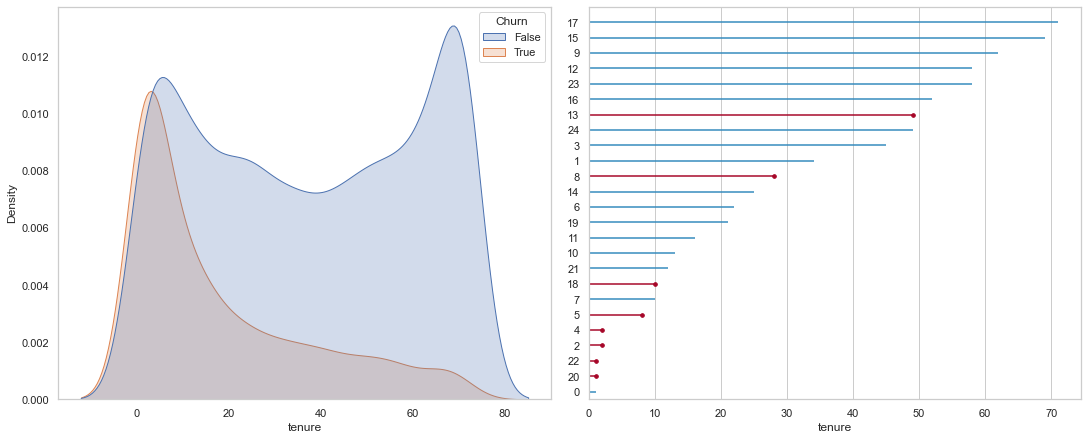

In [43]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,6), constrained_layout=True)

sns.kdeplot(data=df, x='tenure', hue='Churn', shade=True, ax=ax1)
ax1.grid(False)

plot_lifetimes(df.iloc[:25]['tenure'], event_observed=df.iloc[:25]['Churn'], ax=ax2)
ax2.grid(False, axis='y')
ax2.set_xlabel("tenure");

orange distribution makes sense (exponential decay pretty much)
the blue one is 0 inflated because of people with low tenure (new customers who haven't had the chance to churn)
data is censored but we don't have 'actual lifetime' unlike the dummy scenario

# Survival function

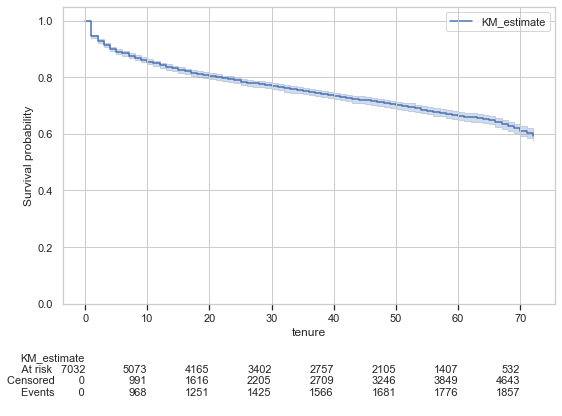

In [44]:
kmf = KaplanMeierFitter()
kmf.fit(df['tenure'], event_observed=df['Churn'])

ax = kmf.plot_survival_function(at_risk_counts=True, figsize=(8,6))
ax.set(xlabel='tenure', ylabel='Survival probability', ylim=(0,1.05));

overall the customer base is pretty healthy
notice the survival probability doesn't go below 60%
the decay is also pretty gently

In [45]:
def func(df, col_name, zero_yaxis=False):
    fig, ax = plt.subplots(figsize=(10,6), constrained_layout=True)
    fig.suptitle(f"Lifespans of different {col_name}")
    
    for grp, grp_df in df.groupby(col_name):
        kmf = KaplanMeierFitter()
        kmf.fit(grp_df['tenure'], event_observed=grp_df['Churn'], label=grp)
        kmf.plot_survival_function(ax=ax)
        ax.set(xlabel='tenure', ylabel='Survival Probability')
        if zero_yaxis:
            ax.set_ylim(0,1.05)
    return ax

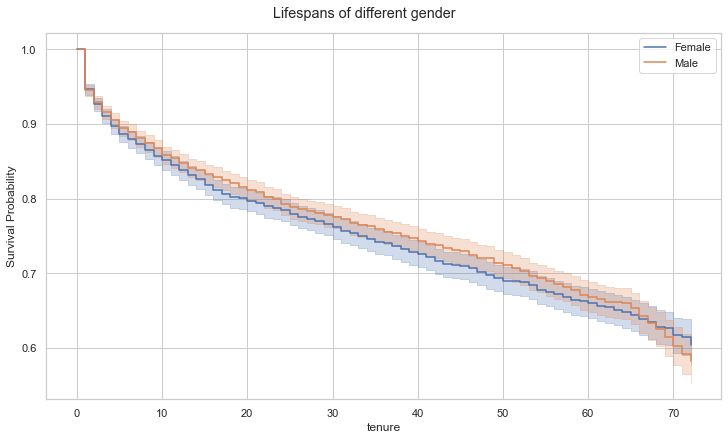

In [46]:
func(df, 'gender');
# func(df, 'SeniorCitizen');
# func(df, 'Contract');
# func(df, 'InternetService');
# func(df, ['Contract','InternetService']);

looking at splits by variables
genders are identical (good to find a variable like this which can work as a virtual control)
senior citizens have a faster decay rate
monthly contract has a much higher churn rate which kind of makes sense but this extreme?
having an internet connection reduces survival chances (especially so for fiber)
interaction effects

# Cox Regression

In [10]:
enc = OrdinalEncoder(dtype=int)
cat_cols = df.select_dtypes('O').drop('customerID', axis=1).columns
df_proc = df.copy()
df_proc[cat_cols] = enc.fit_transform(df_proc[cat_cols])
df_proc.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,False
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,False
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,True
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,False
4,9237-HQITU,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,True


In [42]:
pd.crosstab(df_proc['InternetService'], df['InternetService'])

InternetService,DSL,Fiber optic,No
InternetService,,,
0,2416,0,0
1,0,3096,0
2,0,0,1520


In [12]:
pd.crosstab(df_proc['Contract'], df['Contract'])

Contract,Month-to-month,One year,Two year
Contract,,,
0,3875,0,0
1,0,1472,0
2,0,0,1685


In [13]:
df_train, df_test = train_test_split(df_proc, test_size=0.2, random_state=42)

In [14]:
cph = CoxPHFitter()
cph.fit(df_train.drop('customerID', axis=1), 
        duration_col='tenure', event_col='Churn',
        formula='InternetService + Contract + InternetService * Contract')

<lifelines.CoxPHFitter: fitted with 5625 total observations, 4130 right-censored observations>

In [15]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 5625 total observations, 4130 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 5625
number of events observed = 1495
   partial log-likelihood = -11116.87
         time fit was run = 2021-04-27 10:19:19 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
Contract                  -2.07       0.13       0.10            -2.26            -1.88                 0.10                 0.15
InternetService            0.09       1.09       0.05            -0.00             0.18                 1.00                 1.20
Contract:InternetService  -0.14       0.87       0.09            -0.32             0.03                 0.73                 1.03

                              z      p   -log2(p)
covariate                                        
Contract                 -21.16 <0.005     327.71
InternetService            1.90   0.06       4.13
Contract:InternetService  -1.62   0.11       3.25
---
Concordance = 0.78
Partial AIC = 22239.75
log-likelihood ratio test = 2142.33 on 3 df
-log2(p) of ll-ratio test = inf

the model fitted is $S(t) = \beta_1 InternetService + \beta_2 Contract + \beta_3 (InternetService * Contract)$

contract variable is most important (checks out based on our earlier plot)

<AxesSubplot:>

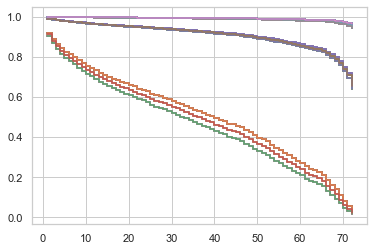

In [16]:
preds = cph.predict_survival_function(df_test.drop('customerID', axis=1))
preds.plot.line(drawstyle='steps-post', legend=False)

we can make customer-wise predictions using this model as well
there's a group of customers which perform much worse (monthly based on shape of plot)

In [17]:
poor_performers_idx = preds.columns[preds.loc[70] < 0.2]
poor_performers = df.loc[poor_performers_idx]
len(poor_performers)

788

In [18]:
poor_performers['InternetService'].value_counts()

Fiber optic    437
DSL            254
No              97
Name: InternetService, dtype: int64

In [19]:
poor_performers['Contract'].value_counts()

Month-to-month    788
Name: Contract, dtype: int64

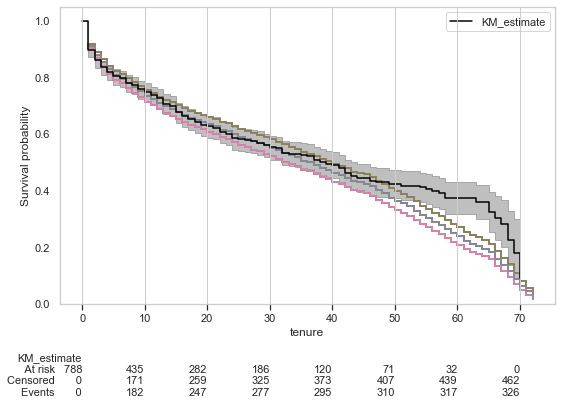

In [47]:
fig, ax = plt.subplots(figsize=(8,6))

preds[preds.columns[preds.loc[70] < 0.2]].plot.line(drawstyle='steps-post', legend=False, ax=ax)

kmf = KaplanMeierFitter()
kmf.fit(poor_performers['tenure'], event_observed=poor_performers['Churn'])
kmf.plot_survival_function(at_risk_counts=True, color='black', ax=ax)

ax.grid(False)
ax.set(xlabel='tenure', ylabel='Survival probability', ylim=(0,1.05));

manual way of checking model fit 
black line is fitted survial curve for these customers (this can only be made using true tenure and churn flags)
regression can be tuned to over/underestimate as you see fit
more robust ways of goodness of fit check also available (concordance index)

# Customer Lifetime Value

In [87]:
# for the nan customers their survival probability never goes below 50% so median is not defined
median_lifetimes = pd.Series(np.where(preds.min() <= 0.5, (preds <= 0.5).idxmax(), np.nan))
(median_lifetimes
 .value_counts(dropna=False, normalize=True)
 .sort_index()
)

33.0    0.068941
36.0    0.310590
40.0    0.180526
NaN     0.439943
dtype: float64

In [88]:
# these both can be obtained from historical data for estimation
avg_order_size = exponential(4000, len(median_lifetimes))
avg_num_orders = exponential(10, len(median_lifetimes))

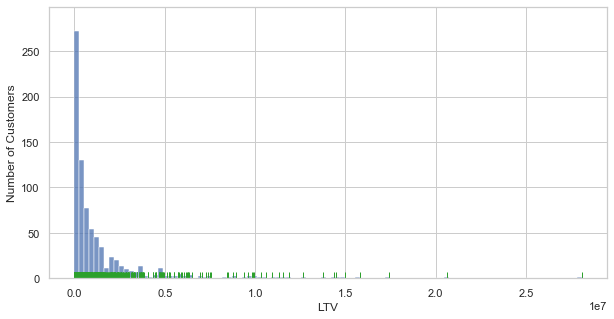

In [102]:
LTV = median_lifetimes * avg_order_size * avg_num_orders

fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(LTV, ax=ax)
sns.rugplot(LTV, color='tab:green',  ax=ax)
ax.set(xlabel='LTV', ylabel='Number of Customers');